In [1]:
import sys

!conda install --yes --prefix {sys.prefix} pandas
!conda install --yes --prefix {sys.prefix} pyodbc
!conda install --yes --prefix {sys.prefix} numpy
!conda install --yes --prefix {sys.prefix} matplotlib
!conda install --yes --prefix {sys.prefix} nltk
!conda install --yes --prefix {sys.prefix} keras

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\csorensen\.conda\envs\test

  added / updated specs:
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.6.16          |           py37_1         156 KB
    pandas-0.25.0              |   py37ha925a31_0         9.8 MB
    ------------------------------------------------------------
                                           Total:        10.0 MB

The following packages will be UPDATED:

  certifi                                  2019.6.16-py37_0 --> 2019.6.16-py37_1
  pandas                              0.24.2-py37ha925a31_0 --> 0.25.0-py37ha925a31_0




pandas-0.25.0        | 9.8 MB    |            |   0% 
pandas-0.25.0        | 9.8 MB    | 5          |   6% 
pandas-0.25.0        | 9.8 MB    | 8          |   8% 
pandas-0.25.0        | 9.8 MB    | ##1        |  22% 
panda



==> WARNING: A newer version of conda exists. <==
  current version: 4.7.5
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base -c defaults conda




Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.7.5
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base -c defaults conda




Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.7.5
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base -c defaults conda




Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.7.5
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base -c defaults conda




Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.7.5
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base -c defaults conda




Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.7.5
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base -c defaults conda




In [2]:
#all the imports used in the program

import pandas as pd 
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
import nltk 
from nltk.corpus import stopwords
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM, GlobalMaxPool1D, Dropout, GRU, Flatten

Using TensorFlow backend.


In [3]:
#Grab data from a database

def getData(Server, UID, PWD, Database, query):    
    
    #create a SQL connection based on the given server and database
    sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                              'SERVER='+Server+';' 
                              'UID='+UID+';'
                              'PWD='+PWD+';'
                              'DATABASE='+Database+';' )
    
    #return the data from the given Query and SQL connection,
    #here i hard coded the index so all queries must select examCode
    #for other instances just simply change or remove depending on use
    return pd.read_sql(query, sql_conn, index_col ="examCode")

In [4]:
#establish my server and corresponding database to pull data from
server ='GSDEMO2HOST'
database = 'MClinical'
UID = 'gsanalytics'
PWD = 'G3st@lt'

#this query grabs sectionValues with their corresponding examCode
#does not select examCodes if there is less than 100 section values for the corresponding examCode
#Stores the result in a pandas DataFrame object called data
query = "SELECT examCode, sectionValue FROM [MClinical].[dbo].[Result] LEFT JOIN ResultSection ON Result.resultKey = ResultSection.resultKey left join mapResultRequestedProcedure ON Result.resultKey = mapResultRequestedProcedure.resultKey left join RequestedProcedure ON mapResultRequestedProcedure.requestedProcedureKey = RequestedProcedure.requestedProcedureKey left join FillerOrder ON RequestedProcedure.fillerOrderKey = FillerOrder.fillerOrderKey left join PlacerOrder ON FillerOrder.placerOrderKey = PlacerOrder.placerOrderKey left join ExamCode ON PlacerOrder.examCodeKey = ExamCode.examCodeKey WHERE (ResultSection.sectionCategory = 'FINAL PATHOLOGIC DIAGNOSIS') AND (ResultSection.sectionValue <>' ') AND (ResultSection.sectionValue <>' No diagnosis; performed technical only ') AND examCode not in ( select examCode FROM [MClinical].[dbo].[Result] LEFT JOIN ResultSection ON Result.resultKey = ResultSection.resultKey left join mapResultRequestedProcedure ON Result.resultKey = mapResultRequestedProcedure.resultKey left join RequestedProcedure ON mapResultRequestedProcedure.requestedProcedureKey = RequestedProcedure.requestedProcedureKey left join FillerOrder ON RequestedProcedure.fillerOrderKey = FillerOrder.fillerOrderKey left join PlacerOrder ON FillerOrder.placerOrderKey = PlacerOrder.placerOrderKey left join ExamCode ON PlacerOrder.examCodeKey = ExamCode.examCodeKey WHERE (ResultSection.sectionCategory = 'FINAL PATHOLOGIC DIAGNOSIS') AND (ResultSection.sectionValue <>' ') AND (ResultSection.sectionValue <>' No diagnosis; performed technical only ') group by examCode having COUNT(examCode) < 3800 ) ORDER BY examCode"
data = getData(server, UID, PWD, database, query)

#this query is a unique list of exam codes from the previous query, this will be useful later
#Stored the result in a pandas DataFrame object called unique_labels
query = "SELECT DISTINCT examCode FROM [MClinical].[dbo].[Result] LEFT JOIN ResultSection ON Result.resultKey = ResultSection.resultKey left join mapResultRequestedProcedure ON Result.resultKey = mapResultRequestedProcedure.resultKey left join RequestedProcedure ON mapResultRequestedProcedure.requestedProcedureKey = RequestedProcedure.requestedProcedureKey left join FillerOrder ON RequestedProcedure.fillerOrderKey = FillerOrder.fillerOrderKey left join PlacerOrder ON FillerOrder.placerOrderKey = PlacerOrder.placerOrderKey left join ExamCode ON PlacerOrder.examCodeKey = ExamCode.examCodeKey WHERE (ResultSection.sectionCategory = 'FINAL PATHOLOGIC DIAGNOSIS') AND (ResultSection.sectionValue <>' ') AND (ResultSection.sectionValue <>' No diagnosis; performed technical only ') AND examCode not in ( select examCode FROM [MClinical].[dbo].[Result] LEFT JOIN ResultSection ON Result.resultKey = ResultSection.resultKey left join mapResultRequestedProcedure ON Result.resultKey = mapResultRequestedProcedure.resultKey left join RequestedProcedure ON mapResultRequestedProcedure.requestedProcedureKey = RequestedProcedure.requestedProcedureKey left join FillerOrder ON RequestedProcedure.fillerOrderKey = FillerOrder.fillerOrderKey left join PlacerOrder ON FillerOrder.placerOrderKey = PlacerOrder.placerOrderKey left join ExamCode ON PlacerOrder.examCodeKey = ExamCode.examCodeKey WHERE (ResultSection.sectionCategory = 'FINAL PATHOLOGIC DIAGNOSIS') AND (ResultSection.sectionValue <>' ') AND (ResultSection.sectionValue <>' No diagnosis; performed technical only ') group by examCode having COUNT(examCode) < 3800 ) ORDER BY examCode"
unique_labels = getData(server, UID, PWD, database, query)

#this query is the exact same query as above, just has description tagged onto it, aswell this will be useful later
#Stored the result in a pandas DataFrame object called descriptive_labels
query = "SELECT DISTINCT examCode, description FROM [MClinical].[dbo].[Result] LEFT JOIN ResultSection ON Result.resultKey = ResultSection.resultKey left join mapResultRequestedProcedure ON Result.resultKey = mapResultRequestedProcedure.resultKey left join RequestedProcedure ON mapResultRequestedProcedure.requestedProcedureKey = RequestedProcedure.requestedProcedureKey left join FillerOrder ON RequestedProcedure.fillerOrderKey = FillerOrder.fillerOrderKey left join PlacerOrder ON FillerOrder.placerOrderKey = PlacerOrder.placerOrderKey left join ExamCode ON PlacerOrder.examCodeKey = ExamCode.examCodeKey WHERE (ResultSection.sectionCategory = 'FINAL PATHOLOGIC DIAGNOSIS') AND (ResultSection.sectionValue <>' ') AND (ResultSection.sectionValue <>' No diagnosis; performed technical only ') AND examCode not in ( select examCode FROM [MClinical].[dbo].[Result] LEFT JOIN ResultSection ON Result.resultKey = ResultSection.resultKey left join mapResultRequestedProcedure ON Result.resultKey = mapResultRequestedProcedure.resultKey left join RequestedProcedure ON mapResultRequestedProcedure.requestedProcedureKey = RequestedProcedure.requestedProcedureKey left join FillerOrder ON RequestedProcedure.fillerOrderKey = FillerOrder.fillerOrderKey left join PlacerOrder ON FillerOrder.placerOrderKey = PlacerOrder.placerOrderKey left join ExamCode ON PlacerOrder.examCodeKey = ExamCode.examCodeKey WHERE (ResultSection.sectionCategory = 'FINAL PATHOLOGIC DIAGNOSIS') AND (ResultSection.sectionValue <>' ') AND (ResultSection.sectionValue <>' No diagnosis; performed technical only ') group by examCode having COUNT(examCode) < 3800 ) ORDER BY examCode"
descriptive_labels = getData(server, UID, PWD, database, query)

In [5]:
#removes words that have at one colon somewhere in the middle of two words
#and words that have two colons separated by three words. 

def removeColon(df):
    
    #Word array of words that i will later remove
    bagOfWords = []
    
    #a array of every word in the sectionValue on the given dataframe df
    wordList = df.sectionValue.str.split(expand=True).stack()
    
    for word in wordList:
        colonWord = re.search(r"\w+:\w+:\w+", word)
        if colonWord is None:
            colonWord = re.search(r"\w+:\w+", word)
        if colonWord is not None:
            if colonWord.group() not in bagOfWords:
                bagOfWords.append(colonWord.group())
    
    #return the updated dataframe sectionValue, only keeping words that are not contained in bagOfWords            
    return df['sectionValue'].apply(lambda x: ' '.join([word for word in x.split() if word not in (bagOfWords)]))

This method is more useful than it looks.

You pass in a pandas DataFrame and tweak it.

First, i create a empty list called bagOfWords

The next line seemes confusing but bassically what I am doing here is taking every word from the sectionValue column and creating a list in which each row only contains one word. This helps with the iterative process. I store the result of this into WordList(approx 1.4 million words)

Next, i iterate through every word in the wordList in a for loop.

let me explain how the search process works and what words i am looking to add to my bagOfWords
1. How does the search processWork?
    1. I use Regex(regular expression) to do my searching for me which is on a character by character basis
2. What kind of words am i looking for?
    1. \w+:\w+ and \w+:\w+:\w+
        1. \w searches for any character in the form [a-zA-Z0-9]
        2. \+ searches for the previous search condition until the end of the word. 
        3. : specifies that i want a colon 
        4. putting it all together 
            1. \w+:\w+ searches for a character in the form [a-zA-Z0-9] for any amount of characters in that form until it hits a colon : in which then it does the same \w+ until the end of the word.
            2. \w+:\w+:\w+ is the same as above just has two colons i hope you get the picture..
            
     
Since i am searching for two different types of words i need to search two different times for every word in wordList.

I search the word to see if it matches the pattern of having three words separated by 2 colons, this returns a match object which i store in colonWord.

if the word isnt found in the search it returns None, so i check if colonWord is None. If it is i search for the different type of word and store that searches result into colonWord.

After that process is done i finally check to see if either of my searches came back true(not None)

If they do i use colonWord.group() function to grab just the string(word) that it found.

Then Check the bagOfWords to see if the word i found is already in it. 

If the word is already in it I move onto the next word in the wordList.

if it is not, i simply  add it and move to the next word as well. 

Finally once i have scanned all words and created my bagOfWords that is a unique list i remove those words from the sectionValue column of the Data. 

what the last line in the funtion is doing is recreating my column sectionValue, but only keeping words that are NOT in bagOfWords.

Once that is done i return the new column of sectionValue. 

In [6]:
#here i wanted to remove punctuation from the column sectionValue in my pandas dataFrame
#i replace every character that matches with one of the following below with nothing.

def removePunctuation(df1):
    df1['sectionValue'] = df1['sectionValue'].str.replace(',', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('.', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('?', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('/', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('/', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('+', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('-', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('=', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('_', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace(')', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('(', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('*', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('&', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('^', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('%', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('$', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('#', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('@', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('!', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('>', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('<', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('[', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace(']', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('{', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('}', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('|', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace(':', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace(';', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('\'', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('\"', '')
    return df1
    

In [7]:
def removeStopWords(df):
    
    #stopWords are words that have relatively no meaning to any actual data
    #we dont want that here so lets remove them
    stop = stopwords.words('english')
    
    # add custom stopWords 
    stop = addStopWords(stop)
    
    # add this if you want to remove words that are smaller than size two
    # change the size to whatever you like 
    
    #df['sectionValue'] = df['sectionValue'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))
    
    #returning the new sectionValue to the Datafram with words that are not in the StopWords
    return df['sectionValue'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [8]:
#adding my own custom stopWords
#super simple to add as you can see 
#modify as needed!

def addStopWords(stop):
    stop.append('-')
    stop.append('a')
    stop.append('b')
    stop.append('c')
    stop.append('d')
    stop.append('e')
    stop.append('f')
    stop.append('g')
    stop.append('h')
    stop.append('i')
    stop.append('j')
    stop.append('k')
    stop.append('l')
    stop.append('m')
    stop.append('n')
    stop.append('o')
    stop.append('p')
    stop.append('q')
    stop.append('r')
    stop.append('s')
    stop.append('t')
    stop.append('u')
    stop.append('v')
    stop.append('w')
    stop.append('x')
    stop.append('y')
    stop.append('z')
    stop.append('no')
    stop.append('see')
    stop.append('two')
    stop.append('0')
    stop.append('1')
    stop.append('2')
    stop.append('3')
    stop.append('4')
    stop.append('5')
    stop.append('6')
    stop.append('7')
    stop.append('8')
    stop.append('9')
    return stop

In [ ]:
#change the case of all the words to lower case so there is no case sensitivity.
data['sectionValue'] = data['sectionValue'].str.lower()

#call the removeColon function to remove words with a colon or mulitple colons in the middle of the word
data['sectionValue'] = removeColon(data)

#call the removePuncuation code, notice how i did this after the removeColon function.
#it is important that we call this after the removeColon Function because this would remove colons
#from words we want to remove, and then the remove colon function would never find anything because there is no colons. 
data = removePunctuation(data)

#call the removeStopWords function to remove words that have no meaning.
data['sectionValue'] = removeStopWords(data)

In [ ]:
def generateWordIndex(df):
    
    # take the data frame and create a word count of all words in the sectionValue and return the series object(word, frequency)
    return df.sectionValue.str.split(expand=True).stack().value_counts()

In [ ]:
#generate the report for the specific label(examCode)

def generateReport(word_index, label):
    
    #print the top 25 words
    print(word_index[:25])
    
    #create an array from 1 to however many words you wish to display
    #:25 grabs the first 25 in an array in python, 25: grabs the last 25 in an array
    x = np.arange(len(word_index[:25]))
    
    #at first every bar is labeled by a number, with the corresponding frequency
    # this gets changed 
    plt.bar(x, height= word_index.values[:25])
    
    #as promised we change the bar name from a index number to its actual number
    #given by the index of the word_index, again only the first 25 so that it matches each number
    #to the corresponding word
    plt.xticks(x, word_index.index[:25], rotation=80)
    
    #this is where it was nice having the exam code be the index for all of my dataframes.
    #here i create the title by the examCode, then the description of the cooresponding examCode
    plt.title(label + "\n" + descriptive_labels.description[label])
    plt.ylabel("Frequency")
    plt.show()
    
    #we clear the plot after every call so that if the function is to be called again it is good to go
    plt.clf()
    
    

COL-P
A. COLON POLYP 

colon           15979
polyp           15228
adenoma         11878
tubular         11432
biopsy           8206
polypectomy      6818
fragments        5770
hyperplastic     4887
dysplasia        4599
negative         4416
ascending        4316
transverse       4023
polyps           3134
mucosa           3082
descending       2889
colonic          2787
malignancy       2662
highgrade        2471
sigmoid          2200
biopsies         2154
cecum            2041
benign           1984
case             1722
reviewed         1722
dictated         1711
dtype: int64


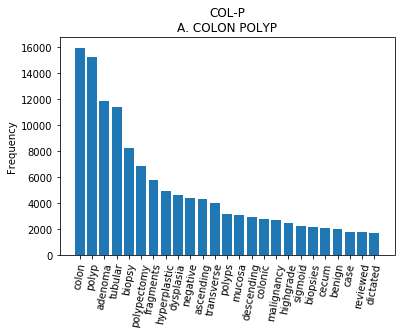



COLBX
A. COLON BIOPSY 

colon           5963
negative        4940
biopsy          4365
colitis         3664
mucosa          3580
dysplasia       3439
colonic         3155
biopsies        2244
malignancy      1695
benign          1664
active          1503
chronic         1438
random          1404
polyp           1357
fragments       1291
diagnostic      1175
sigmoid         1164
adenoma         1125
microscopic      999
tubular          972
granulomas       921
abnormality      912
ascending        855
hyperplastic     832
bowel            830
dtype: int64


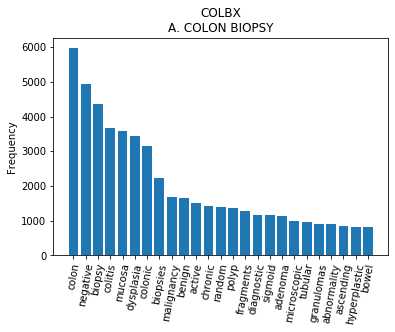



EMBX1
A. ENDOMETRIAL BIOPSY 

endometrium      16799
endometrial      13615
biopsy           13274
hyperplasia       8646
malignancy        7042
atypia            6969
negative          6121
benign            5882
proliferative     5780
fragments         4113
cytologic         3225
polyp             3104
without           2760
glandular         2374
identified        2283
endocervical      2267
secretory         2117
stromal           1912
tissue            1785
breakdown         1729
epithelium        1636
strips            1471
evidence          1454
weakly            1424
pattern           1393
dtype: int64


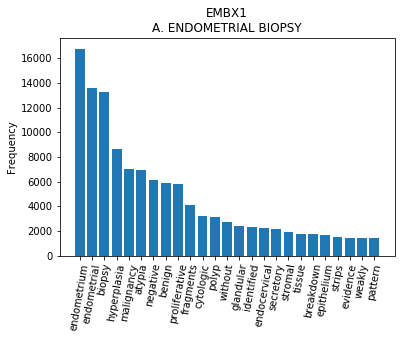



GALLB
A. GALLBLADDER 

gallbladder        6002
cholecystitis      5126
chronic            5034
cholecystectomy    4880
cholelithiasis     3724
cholesterolosis    1244
acute               984
mild                885
benign              776
negative            597
lymph               542
node                506
calculous           372
malignancy          367
gross               339
inflammation        315
focal               313
mucosal             310
changes             283
dysplasia           276
identified          259
excision            245
reactive            237
reviewed            221
dictated            221
dtype: int64


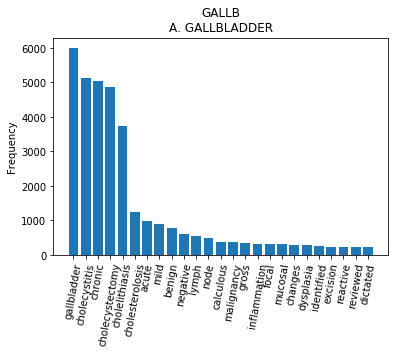



KAD-PLAC 3T GRS
A. PLACENTA GROSS ONLY 

placenta        4722
cord            4719
trivascular     4712
term            4711
grossly         4711
described       4709
grams           3742
umbilical       1856
fallopian        322
tube             240
pathologic       106
sections          96
cross             94
complete          89
identified        85
tubes             82
left              81
right             79
abnormality       73
full              62
diagnosis         56
without           56
tubal             55
crosssection      54
ligation          53
dtype: int64


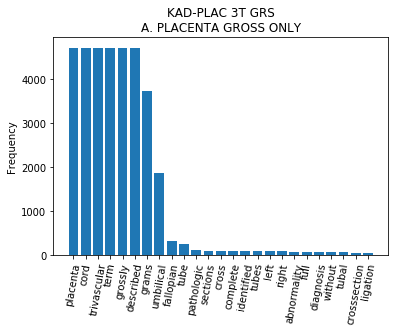



SK-NWD
A. SKIN FOR DERM,OTHER THAN SKC1D 

skin                  6581
biopsy                6572
shave                 5888
case                  4543
reviewed              4542
dermatopathologist    4538
dictated              4533
boardcertified        3382
alden                 3377
webb                  3374
left                  3049
present               3024
right                 2871
lateral               2633
cell                  2004
carcinoma             1977
deep                  1931
margins               1914
margin                1832
keratosis             1764
nevus                 1489
upper                 1329
basal                 1317
type                  1257
md                    1165
dtype: int64


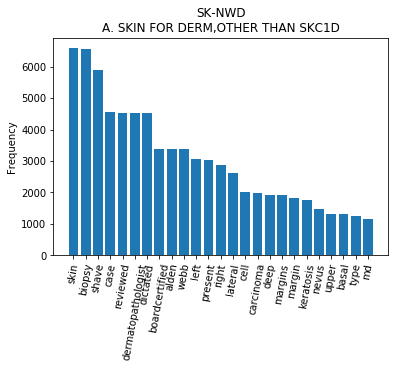



SK-VD
A. SKIN FOR DERM, OTHER THAN SKC1D 

biopsy                4524
skin                  4467
shave                 3748
case                  3091
reviewed              3088
dermatopathologist    3084
dictated              3080
boardcertified        2145
lateral               2139
alden                 2132
webb                  2132
right                 2065
left                  2063
present               2014
deep                  1347
margins               1292
nevus                 1126
cell                  1120
carcinoma             1098
keratosis             1031
margin                1019
md                     957
zhang                  943
certified              942
board                  942
dtype: int64


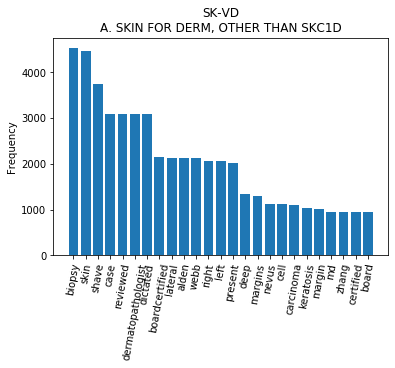



SKO1
A. SKIN, OTHER THAN SKC1 

skin                  51418
biopsy                43057
shave                 24894
case                  23626
reviewed              23623
dictated              23496
dermatopathologist    22984
left                  22629
right                 21678
boardcertified        19951
md                    16417
carcinoma             14145
keratosis             13610
present               13412
cell                  13407
nevus                 11488
punch                  9547
lateral                9218
comment                8903
basal                  8769
margin                 7808
seborrheic             7676
herreid                7598
peter                  7581
benign                 7409
dtype: int64


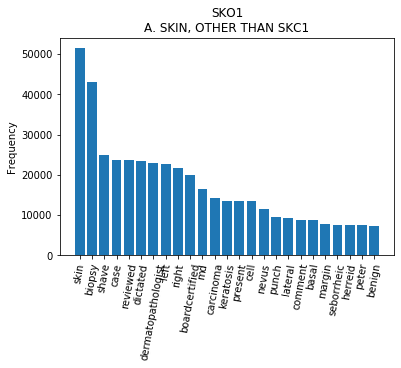



SKO2
A. SKIN, OTHER THAN CYST/TAG/DEBRIDEMENT/PLASTIC REPAIR - 2 BLOCKS 

skin                  4163
excision              3256
carcinoma             2444
cell                  2229
left                  1879
residual              1862
biopsy                1808
right                 1715
case                  1496
reviewed              1495
dictated              1491
dermatopathologist    1452
margins               1425
basal                 1397
margin                1263
md                    1219
changes               1195
site                  1187
boardcertified        1055
negative              1004
lateral                920
squamous               901
present                731
mm                     661
absent                 629
dtype: int64


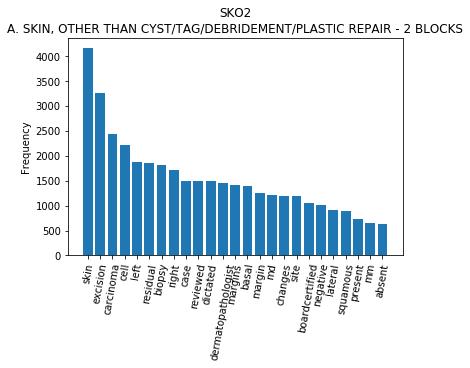



USBRSTNBX
A. ULTRASOUND GUIDED BREAST NEEDLE BIOPSY 

breast                 8034
score                  6220
tumor                  4713
oclock                 4260
biopsy                 4192
grade                  3911
core                   3818
needle                 3332
left                   2985
ultrasoundguided       2979
right                  2861
carcinoma              2741
receptor               2684
ductal                 2211
microcalcifications    2098
identified             2091
benign                 2072
negative               2017
nuclear                2008
atypia                 1890
present                1815
absent                 1798
tissue                 1733
features               1720
mm                     1557
dtype: int64


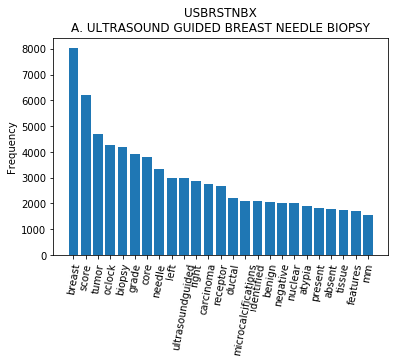

<Figure size 432x288 with 0 Axes>

In [ ]:
#grab every examCode one by one and store it in label

for label in unique_labels.index:
    
    #print the examCode and its description
    print(label)
    print(descriptive_labels.description[label],'\n')
    
    #this is another reason i made the exam code the index, 
    #here i simply grab every section value with the examCode matching to the examCode stored in label
    # store it in a Pandas series datafram which keeps the coloumns and indexs from the dataFrame
    sf = data.sectionValue[label]
    
    #convert the series with only sectionValues that are for the current examCode
    #back to a pandas DataFrame object.
    temp = pd.DataFrame({'examCode':sf.index, 'sectionValue':sf.values})
    
    #get a word_index for the given examCode's sectionValues
    word_Index = generateWordIndex(temp)
    
    #generate the report for the word_index and corresponding ExamCode
    generateReport(word_Index, label)
    
    #create space to help make things stay separated
    print('\n')
    

In [ ]:
def concatExamDesc(df,desc):
    temp1 = pd.DataFrame(columns =['examCode','sectionValue'] )
    for label in desc.index:
        description = desc.description[label]
        sf = df.sectionValue[label]
        add = pd.DataFrame({'examCode':sf.index, 'sectionValue': sf.values})
        add['sectionValue'] = description + add.sectionValue.astype(str)
        add = add.set_index('examCode', drop = False)
        temp1 = temp1.append(add) 
    return temp1['sectionValue']

In [ ]:
temp = data.copy()
temp['sectionValue'] = concatExamDesc(temp, descriptive_labels)
print(temp)

                                                sectionValue
examCode                                                    
COL-P      A. COLON POLYPcolon transverse biopsy hyperpla...
COL-P      A. COLON POLYPtransverse colon polyp biopsy tu...
COL-P      A. COLON POLYPcolon transverse biopsies tubula...
COL-P      A. COLON POLYPcolon transverse biopsies tubula...
COL-P      A. COLON POLYPcolon cecum biopsy tubular adeno...
...                                                      ...
USBRSTNBX  A. ULTRASOUND GUIDED BREAST NEEDLE BIOPSYright...
USBRSTNBX  A. ULTRASOUND GUIDED BREAST NEEDLE BIOPSYright...
USBRSTNBX  A. ULTRASOUND GUIDED BREAST NEEDLE BIOPSYbreas...
USBRSTNBX  A. ULTRASOUND GUIDED BREAST NEEDLE BIOPSYleft ...
USBRSTNBX  A. ULTRASOUND GUIDED BREAST NEEDLE BIOPSYleft ...

[104784 rows x 1 columns]


In [ ]:
texts = temp.sectionValue
labels = temp.index

texts = texts.values
temp_labels = labels.values

labels = []
label_dict = unique_labels.index
label_dict = label_dict.values

for label_type in temp_labels:
    if label_type == label_dict[0]:
        labels.append(0)
    if label_type == label_dict[1]:
        labels.append(1)
    if label_type == label_dict[2]:
        labels.append(2)
    if label_type == label_dict[3]:
        labels.append(3)
    if label_type == label_dict[4]:
        labels.append(4)
    if label_type == label_dict[5]:
        labels.append(5)
    if label_type == label_dict[6]:
        labels.append(6)
    if label_type == label_dict[7]:
        labels.append(7)
    if label_type == label_dict[8]:
        labels.append(8)
    if label_type == label_dict[9]:
        labels.append(9)

labels =np.asarray(labels)
print(texts.shape)
print(labels.shape)
print(type(texts))
print(type(labels))

(104784,)
(104784,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
maxlen = 100
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Found 10834 unique tokens.
Shape of data tensor: (104784, 100)
Shape of label tensor: (104784,)


In [ ]:
model = Sequential()
model.add(Embedding(input_dim = max_words, input_length=maxlen, output_dim = 50))
model.add(Bidirectional(LSTM(units =32)))
model.add(Dense(10, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                21248     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 521,898
Trainable params: 521,898
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
history = model.fit(data, 
                    labels,
                    epochs=25,
                    batch_size=500,
                    validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 83827 samples, validate on 20957 samples
Epoch 1/25
83827/83827 [==============================] - 55s 657us/step - loss: 0.9727 - acc: 0.7190 - val_loss: 0.3651 - val_acc: 0.9151
Epoch 2/25
83827/83827 [==============================] - 52s 615us/step - loss: 0.1902 - acc: 0.9301 - val_loss: 0.1389 - val_acc: 0.9413
Epoch 3/25
83827/83827 [==============================] - 53s 630us/step - loss: 0.0916 - acc: 0.9579 - val_loss: 0.0733 - val_acc: 0.9699
Epoch 4/25
68500/83827 [=======================>......] - ETA: 16s - loss: 0.0636 - acc: 0.9735

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

print('Validation Accuracy: ', val_acc[np.argmax(val_acc)] * 100)
print('Training Accuracy: ', acc[np.argmax(acc)] * 100)